In [56]:
from lib.utilities import *
import matplotlib.pyplot as plt

%matplotlib widget

In [57]:
############### User Configuration ###############
##################################################

datadir = "./tsm_targets/02-07-22" # All files in this directory + subdirectories are loaded
selected_filename = "Untitled010" # focus for subsequent analysis
file_type = '.tsm'
# Spatial area to investigate
y_range = [250,750]  # recommended for 1024-px widths
#x_range = [0,-2] 

binning=3

# Temporal area to investigate
points_to_skip = 0
if file_type == '.zda':
    points_to_skip = 30
time_window = [points_to_skip,-1]  # zda file has a big spike at t=15
measure_window = [75 - points_to_skip, 95 - points_to_skip]

In [58]:
############## Driver script: begin ##############
##################################################

# Load data
processed = [] # to avoid re-processing later
data_loader = DataLoader()
if file_type == '.tsm':
    data_loader.load_all_tsm(data_dir=datadir + "/tsm_targets")
else:
    data_loader.load_all_zda(data_dir=datadir + "/zda_targets")


.\tsm_targets/Untitled004.tsm to be treated as TSM file to open
Reading file as 200 images of size 1024 x 320
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 1024, 'raw_height': 320, 'interval_between_samples': 1.0, 'number_of_trials': 1}
.\tsm_targets/Untitled005.tsm to be treated as TSM file to open
Reading file as 200 images of size 1024 x 320
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 1024, 'raw_height': 320, 'interval_between_samples': 1.0, 'number_of_trials': 1}
.\tsm_targets\01-17-22/Untitled005.tsm to be treated as TSM file to open
Reading file as 200 images of size 1024 x 320
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 1024, 'raw_height': 320, 'interval_between_samples': 1.0, 'number_of_trials': 1}
.\tsm_targets\01-17-22/Untitled006.tsm to be treated as TS

In [59]:
# Select data of interest        
selected_data = data_loader.select_data_by_keyword(selected_filename)

# Clip to the time range 20 ms onward to get rid of the camera "foot"
selected_data.clip_data(t_range=time_window, y_range=y_range)
selected_data.bin_data(binning=binning)

raw_data, meta, rli = selected_data.get_data(), selected_data.get_meta(), selected_data.get_rli()

{'points_per_trace': 199, 'raw_width': 199, 'raw_height': 100, 'interval_between_samples': 1.0, 'number_of_trials': 1} (1, 199, 319, 500)


(1, 199, 107, 167)


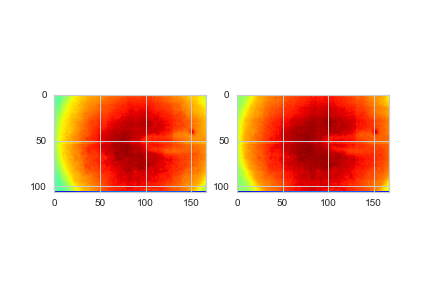

In [60]:
# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='jet')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()

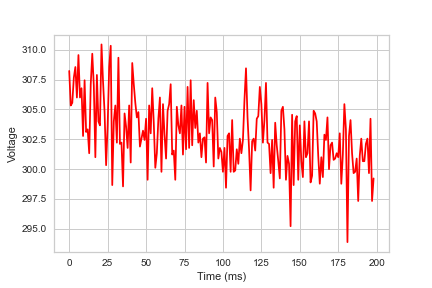

In [61]:
# view a trace
tr = Tracer()
tr.plot_trace(raw_data, 10, 10, meta['interval_between_samples'], trial=0)

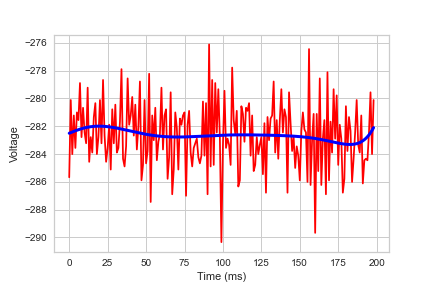

In [62]:
# Run this cell at most once per ZDA load

#data inversing
raw_data = -raw_data

# Need to subtract off the low-frequency voltage drift. First-order correction
tr.correct_background(meta, raw_data)


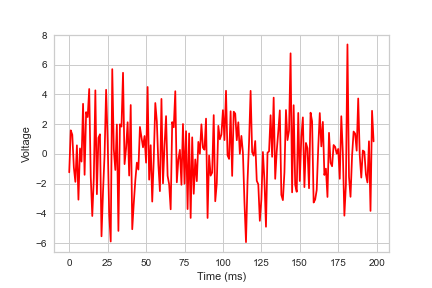

(1, 199, 107, 167)


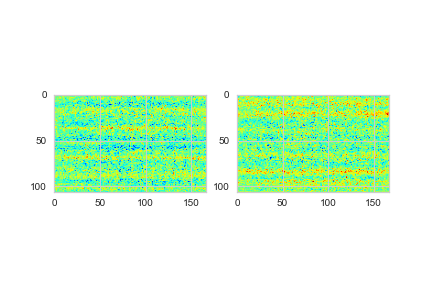

In [63]:

#full trace
tr.plot_trace(raw_data[:,:,:,:], 
           10, 
           10, 
           meta['interval_between_samples'], 
           trial=0)

# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='jet')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()

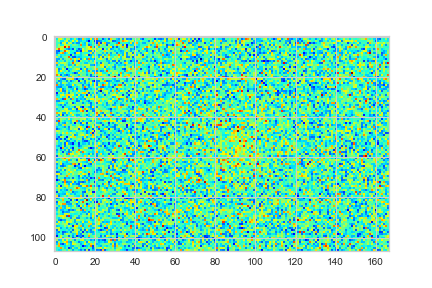

max SNR before: 3.644860160074441 min SNR before: 0.6093151488960872


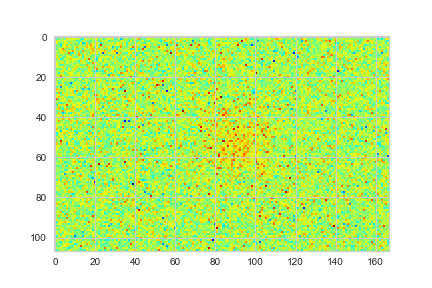

max SNR: 5.01238052369585 min SNR: -2.5754733926314968


In [64]:
# Examine SNR before and after t-filter
sp = SignalProcessor()
filtered_data = sp.filter_temporal(meta, raw_data, sigma_t=2.0)

trial = filtered_data[0, :, :, :] 
trials = filtered_data

trial_before = raw_data[0, :, :, :] 

asnr_before = AnalyzerSNR(trial_before)
snr_before = asnr_before.get_snr(plot=True, window=measure_window)
print("max SNR before:", np.max(snr_before), "min SNR before:", np.min(snr_before))

asnr = AnalyzerSNR(trial)
snr = asnr.get_snr(plot=True, window=measure_window)
print("max SNR:", np.max(snr), "min SNR:", np.min(snr))


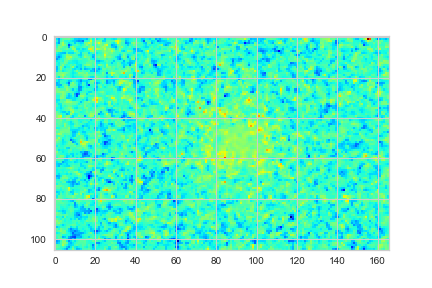

max SNR: 7.204570236394456 min SNR: -2.1826520128827793


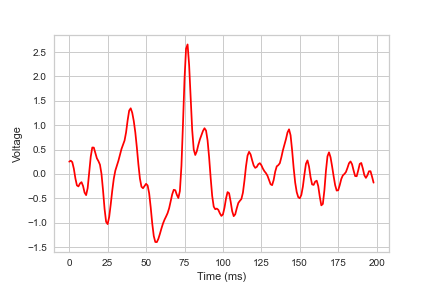

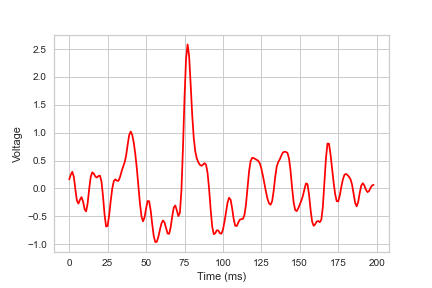

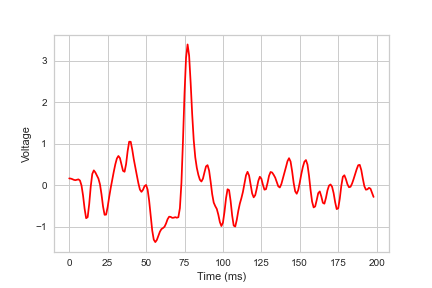

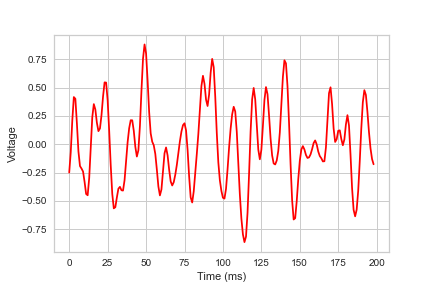

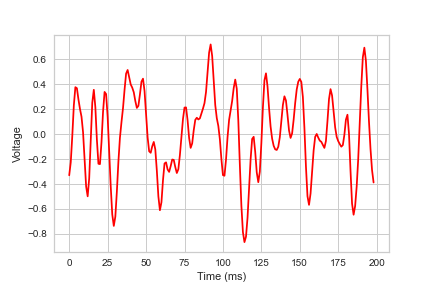

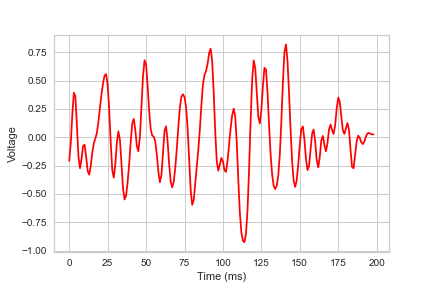

In [65]:
# spatial filtering
filtered_data = sp.filter_spatial(meta, filtered_data)


asnr = AnalyzerSNR(filtered_data[0, :, 1:, 1:])
snr = asnr.get_snr(plot=True, window=measure_window)
print("max SNR:", np.max(snr), "min SNR:", np.min(snr))



tr.plot_trace(filtered_data[:,:,:,:],
           50, 
           95,
           meta['interval_between_samples'], 
           trial=0)

tr.plot_trace(filtered_data[:,:,:,:],
           50, 
           96,
           meta['interval_between_samples'], 
           trial=0)

tr.plot_trace(filtered_data[:,:,:,:],
           51, 
           95,
           meta['interval_between_samples'], 
           trial=0)


tr.plot_trace(filtered_data[:,:,:,:],
           89, 
           50,
           meta['interval_between_samples'], 
           trial=0)

tr.plot_trace(filtered_data[:,:,:,:],
           90, 
           50,
           meta['interval_between_samples'], 
           trial=0)

tr.plot_trace(filtered_data[:,:,:,:],
           89, 
           51,
           meta['interval_between_samples'], 
           trial=0)

Text(0, 0.5, 'Mean SNR')

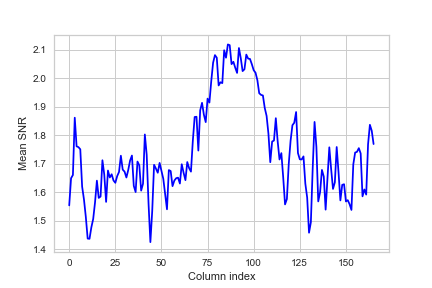

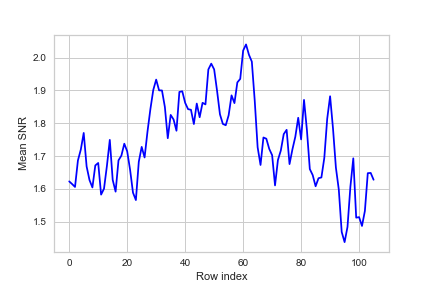

In [74]:
# Plot Mean SNR of each column
SNR_maxes_cols = np.average(snr, axis=0)
i_cols = np.array([i for i in range(SNR_maxes_cols.shape[0])])

fig, ax = plt.subplots()
ax.plot(i_cols, SNR_maxes_cols, color='blue')
ax.set_xlabel("Column index")
ax.set_ylabel("Mean SNR")

# Plot Mean SNR of each row
SNR_maxes_rows = np.average(snr, axis=1)
i_rows = np.array([i for i in range(SNR_maxes_rows.shape[0])])

fig, ax = plt.subplots()
ax.plot(i_rows, SNR_maxes_rows, color='blue')
ax.set_xlabel("Row index")
ax.set_ylabel("Mean SNR")

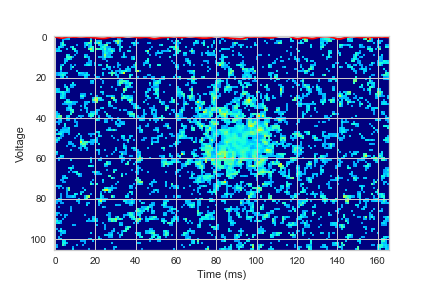

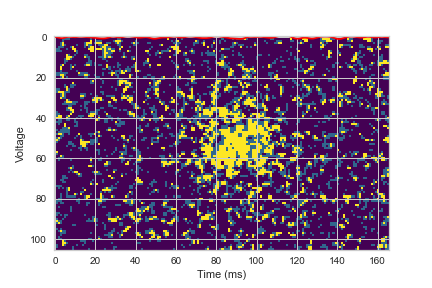

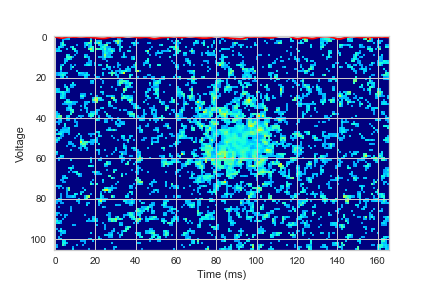

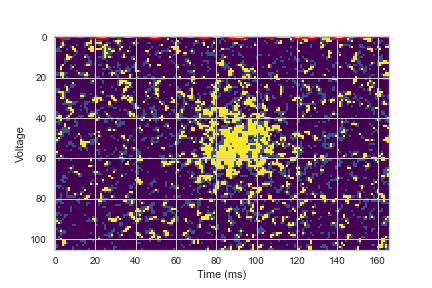

In [66]:
# impose snr cutoff

asnr.cluster_on_snr(plot=True)

snr_percentile_cutoff = 0.7
k_clusters = 3
snr_cutoff = np.percentile(snr, snr_percentile_cutoff * 100)

mask = (snr >= snr_cutoff).astype(np.float)

# masked image: reasonability check
plt.imshow(snr * mask, cmap='jet', interpolation='nearest')
plt.show()

# 1-D K-means clustering of SNR groups
km = KMeans(n_clusters=k_clusters+1).fit(snr.reshape(-1,1)) # +1 for the masked 0's

clustered = np.array(km.labels_).reshape(snr.shape) + 1
clustered = clustered.astype(np.float)

plt.imshow(clustered * mask, cmap='viridis', interpolation='nearest')
plt.show()


In [67]:
# SNR by cluster
avg_snr_by_cluster = [np.average(snr[np.where(clustered==i)[0]]) for  i in range(1, k_clusters+2)]
print(avg_snr_by_cluster)

cluster_indices_by_snr = np.argsort(np.array(avg_snr_by_cluster)) + 1
highest_snr_cluster = cluster_indices_by_snr[-1]
print(cluster_indices_by_snr)
print("highest_snr_cluster =", highest_snr_cluster)

[1.756797244359619, 1.7326231091926947, 1.7053694928913754, 1.7979073857958456]
[3 2 1 4]
highest_snr_cluster = 4


Pixel at (0 , 5)


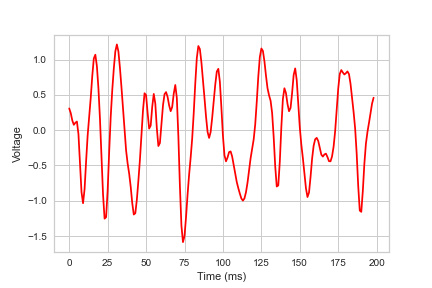

Pixel at (28 , 145)


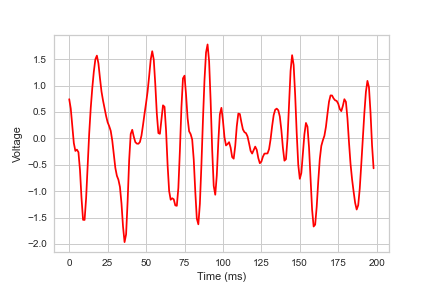

Pixel at (45 , 108)


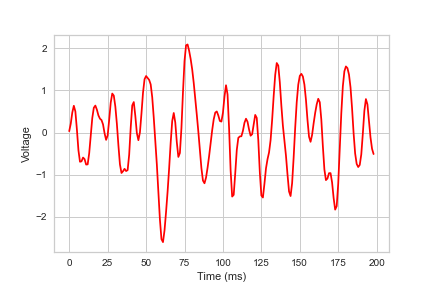

Pixel at (58 , 76)


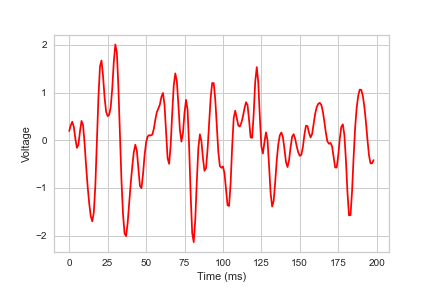

Pixel at (74 , 113)


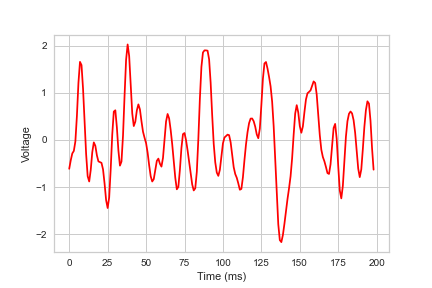

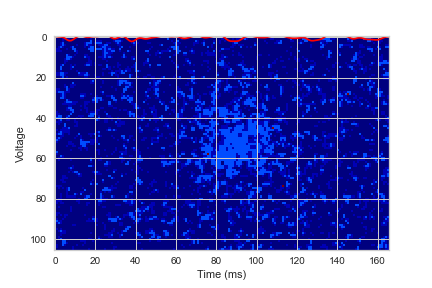

In [68]:
# Examine some higher-SNR pixels
n_samples = 5
mask = (snr >= snr_cutoff).astype(np.float)

# Select the pixels in the highest SNR cluster, above SNR cutoff
argmaxes =  np.where(clustered * mask == highest_snr_cluster)
max_samples = argmaxes[0].shape[0]
for i in range(0, max_samples, int(max_samples / n_samples) ):

    x_max = argmaxes[0][i]
    y_max = argmaxes[1][i]
    print("Pixel at (" + str(x_max), ",", str(y_max) + ")")
    tr.plot_trace(trials[:,:,:,time_window[0]:time_window[1]], 
               x_max, 
               y_max, 
               meta['interval_between_samples'], 
               trial=0)

    mask[x_max, y_max] *= 5 # highlight

plt.imshow(clustered * mask, cmap='jet', interpolation='nearest')
plt.show()


In [ ]:
# Silhouette analysis

print("Silhouette score:", silhouette_score(features, label))

# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=0)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,6), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(features)    
visualizer.poof()   